#  Analiza zmian jeziora Aralskiego (2017–2025)
## Sentinel‑2 + Microsoft Planetary Computer + Apache Sedona

**Cel ćwiczenia:**
1) Pobierz dane Sentinel‑2 (Green – `B03`, NIR – `B08`) z Microsoft Planetary Computer dla jeziora Aralskiego — po 1 scenie na każdy rok 2017–2025 (preferencyjnie czerwiec–sierpień, zachmurzenie < 10%).
2) Wczytaj dane do Apache Sedona (Spark) i wykonaj analizę NDWI: `NDWI = (Green - NIR) / (Green + NIR)`.
3) Zwizualizuj zmiany średniego NDWI w czasie.



##  Środowisko i biblioteki
Zalecane biblioteki:
- `pystac-client`, `planetary_computer`, 

Zainstaluj, jeśli potrzeba (np. dla obrazu Dockera)

In [1]:
import datetime 
import os
import pystac_client
import planetary_computer
import stackstac
import rioxarray as rxr
import numpy as np
from sedona.spark import SedonaContext
import re
from pystac_client import Client
import planetary_computer as pc
import requests
import os
from pystac_client import Client
from planetary_computer import sign as pc_sign
import os, requests


## 1) Pobranie danych z Microsoft Planetary Computer
Napisz funkcję `get_aral_s2(years, bbox)`, która dla każdego roku zwróci po 1 najlepszej scenie Sentinel‑2 L2A (najmniejsze zachmurzenie w czerwcu–sierpniu).

**Wskazówki:**
- Katalog STAC: `https://planetarycomputer.microsoft.com/api/stac/v1`
- Kolekcja: `sentinel-2-l2a`
- Filtrowanie: `datetime`, `bbox`, `eo:cloud_cover < 20`, preferuj letnie miesiące.
- Użyj `planetary_computer.sign()` do podpisywania assets.
- Do wczytania pasm użyj `stackstac.stack()`.

In [4]:
import os
import requests
from pystac_client import Client
import planetary_computer

def get_aral_s2_mgrs(start_year, end_year, mgrs_tile, output_dir):
    """
    Pobiera po 1 najlepszej scenie Sentinel-2 L2A dla każdego roku (najmniejsze zachmurzenie w czerwcu–sierpniu)
    dla wskazanego kafelka MGRS i zapisuje pasma B03 i B08 jako pliki GeoTIFF.

    Parametry:
    ----------
    start_year : int
        Rok początkowy (np. 2017)
    end_year : int
        Rok końcowy (np. 2025)
    mgrs_tile : str
        Id kafelka MGRS (np. '40TGS')
    output_dir : str
        Ścieżka do katalogu, w którym mają być zapisane pliki .tif

    Wynik:
    ------
    None (pliki zostają zapisane lokalnie w output_dir)
    """
    # Utworzenie katalogu wyjściowego
    os.makedirs(output_dir, exist_ok=True)

    # Połączenie z Planetary Computer STAC
    stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # Pętla po latach
    for year in range(start_year, end_year + 1):
        start = f"{year}-06-01"
        end = f"{year}-08-31"
        print(f"\nSzukam najlepszej sceny Sentinel-2 L2A dla {mgrs_tile}, rok {year} ({start} → {end})")

        # Wyszukaj sceny w danym kafelku i zakresie dat
        search = stac.search(
            collections=["sentinel-2-l2a"],
            query={
                "s2:mgrs_tile": {"eq": mgrs_tile},
                "eo:cloud_cover": {"lt": 40}
            },
            datetime=f"{start}/{end}",
            sortby=[{"field": "properties.eo:cloud_cover", "direction": "asc"}],
            limit=1
        )

        items = list(search.items())
        if not items:
            print(f"Brak scen dla roku {year}.")
            continue

        item = items[0]
        date = item.properties["datetime"]
        cloud = item.properties.get("eo:cloud_cover", "?")
        print(f"Wybrano scenę: {item.id} ({date}, zachmurzenie: {cloud}%)")

        # Pobierz pasma B03 i B08
        for band in ["B03", "B08"]:
            asset = item.assets.get(band)
            if not asset:
                print(f"Brak pasma {band} w {item.id}")
                continue

            signed_href = planetary_computer.sign(asset.href)
            out_path = os.path.join(output_dir, f"{year}_{band}_{mgrs_tile}.tif")

            # Pomiń, jeśli plik już istnieje
            if os.path.exists(out_path):
                print(f"Już istnieje: {out_path}")
                continue

            # Pobieranie pliku
            print(f"Pobieram {band} → {out_path}")
            with requests.get(signed_href, stream=True) as r:
                r.raise_for_status()
                with open(out_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=1024 * 1024):
                        f.write(chunk)

            print(f"Zapisano: {out_path}")

    print("\nZakończono pobieranie wszystkich lat.")


In [5]:
get_aral_s2_mgrs(
    start_year=2017,
    end_year=2025,
    mgrs_tile="40TGS",
    output_dir="/opt/workspace/aut/outpucik"
)



Szukam najlepszej sceny Sentinel-2 L2A dla 40TGS, rok 2017 (2017-06-01 → 2017-08-31)
Wybrano scenę: S2B_MSIL2A_20170820T065619_R063_T40TGS_20201015T042054 (2017-08-20T06:56:19.027000Z, zachmurzenie: 0.515466%)
Pobieram B03 → /opt/workspace/aut/outpucik/2017_B03_40TGS.tif
Zapisano: /opt/workspace/aut/outpucik/2017_B03_40TGS.tif
Pobieram B08 → /opt/workspace/aut/outpucik/2017_B08_40TGS.tif
Zapisano: /opt/workspace/aut/outpucik/2017_B08_40TGS.tif

Szukam najlepszej sceny Sentinel-2 L2A dla 40TGS, rok 2018 (2018-06-01 → 2018-08-31)
Wybrano scenę: S2B_MSIL2A_20180828T070609_R106_T40TGS_20201027T060223 (2018-08-28T07:06:09.024000Z, zachmurzenie: 0.0%)
Pobieram B03 → /opt/workspace/aut/outpucik/2018_B03_40TGS.tif
Zapisano: /opt/workspace/aut/outpucik/2018_B03_40TGS.tif
Pobieram B08 → /opt/workspace/aut/outpucik/2018_B08_40TGS.tif
Zapisano: /opt/workspace/aut/outpucik/2018_B08_40TGS.tif

Szukam najlepszej sceny Sentinel-2 L2A dla 40TGS, rok 2019 (2019-06-01 → 2019-08-31)
Wybrano scenę: S2B_MS

## 2) Wczytanie do Apache Sedona i przygotowanie danych NDWI
Utwórz sesję Spark + Sedona. Następnie załaduj raster

In [6]:
config = (
    SedonaContext.builder()
    .config(
        "spark.jars.packages",
        ",".join([
            "org.apache.sedona:sedona-spark-shaded-4.0_2.13:1.8.0",
            "org.datasyslab:geotools-wrapper:1.8.0-33.1",
            "org.apache.hadoop:hadoop-aws:3.3.2"
        ])
    )
    .config("spark.jars.repositories", "https://artifacts.unidata.ucar.edu/repository/unidata-all")        
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "true") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", 
        "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
    .config("spark.executor.memory", "6G")
    .config("spark.driver.memory", "6G")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)
 
sedona = SedonaContext.create(config)
sedona.sparkContext.setLogLevel("ERROR")
 
sedona.conf.set("fs.https.impl", "org.apache.hadoop.fs.http.HttpsFileSystem")

https://artifacts.unidata.ucar.edu/repository/unidata-all added as a remote repository with the name: repo-1
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.sedona#sedona-spark-shaded-4.0_2.13 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3c7d73e8-d959-4182-888d-2f39436ed9b7;1.0
	confs: [default]
	found org.apache.sedona#sedona-spark-shaded-4.0_2.13;1.8.0 in central


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.datasyslab#geotools-wrapper;1.8.0-33.1 in central
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.1026 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 198ms :: artifacts dl 7ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.1026 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.2 from central in [default]
	org.apache.sedona#sedona-spark-shaded-4.0_2.13;1.8.0 from central in [default]
	org.datasyslab#geotools-wrapper;1.8.0-33.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   5   |   0   | 

## 3) Obliczenie NDWI
Uzyj wzoru `ndwi = (green - nir) / (green + nir)` i policz średni NDWI dla każdego roku.

In [9]:
import os
import numpy as np
import rasterio
from pyspark.sql import Row


input_dir = "/opt/workspace/aut/outpucik"
mgrs_tile = "40TGS"

output_dir = os.path.join(input_dir, "sentinel_ndwi")
os.makedirs(output_dir, exist_ok=True)

# Wyszukanie plików B03 i B08
b03_files = sorted([f for f in os.listdir(input_dir) if "_B03_" in f])
b08_files = sorted([f for f in os.listdir(input_dir) if "_B08_" in f])

# Dopasowanie par (B03 ↔ B08) po roku
pairs = []
for b03 in b03_files:
    year = b03.split("_")[0]
    match = [f for f in b08_files if year in f]
    if match:
        pairs.append((year, os.path.join(input_dir, b03), os.path.join(input_dir, match[0])))

print(f"Znaleziono {len(pairs)} par plików do przetworzenia.")

# Funkcja obliczająca NDWI i zapisująca raster
def compute_ndwi(year, b03_path, b08_path):
    try:
        with rasterio.open(b03_path) as b3, rasterio.open(b08_path) as b8:
            green = b3.read(1).astype("float32")
            nir = b8.read(1).astype("float32")

            # NDWI = (Green - NIR) / (Green + NIR)
            ndwi = np.where((green + nir) != 0, (green - nir) / (green + nir), 0)

            profile = b3.profile
            profile.update(dtype=rasterio.float32, count=1, compress='lzw')

            out_path = os.path.join(output_dir, f"{year}_NDWI.tif")
            with rasterio.open(out_path, "w", **profile) as dst:
                dst.write(ndwi, 1)

        return Row(year=int(year), path=out_path)

    except Exception as e:
        print(f"Błąd przy przetwarzaniu {year}: {e}")
        return Row(year=int(year), path=None)

# Równoległe przetwarzanie przez Spark
rdd = sedona.sparkContext.parallelize(pairs, numSlices=min(len(pairs), 4))
results = rdd.map(lambda p: compute_ndwi(*p)).collect()

print("\nZapisano pliki NDWI:")
for r in results:
    if r.path:
        print(f"   {r.year} → {r.path}")



Znaleziono 9 par plików do przetworzenia.


/tmp/ipykernel_31139/380725962.py:35: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_31139/380725962.py:35: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_31139/380725962.py:35: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_31139/380725962.py:35: RuntimeWarning: invalid value encountered in divide



Zapisano pliki NDWI:
   2017 → /opt/workspace/aut/outpucik/sentinel_ndwi/2017_NDWI.tif
   2018 → /opt/workspace/aut/outpucik/sentinel_ndwi/2018_NDWI.tif
   2019 → /opt/workspace/aut/outpucik/sentinel_ndwi/2019_NDWI.tif
   2020 → /opt/workspace/aut/outpucik/sentinel_ndwi/2020_NDWI.tif
   2021 → /opt/workspace/aut/outpucik/sentinel_ndwi/2021_NDWI.tif
   2022 → /opt/workspace/aut/outpucik/sentinel_ndwi/2022_NDWI.tif
   2023 → /opt/workspace/aut/outpucik/sentinel_ndwi/2023_NDWI.tif
   2024 → /opt/workspace/aut/outpucik/sentinel_ndwi/2024_NDWI.tif
   2025 → /opt/workspace/aut/outpucik/sentinel_ndwi/2025_NDWI.tif


## 4) Wykres zmian NDWI (2017–2025)
Utwórz wykres liniowy średniego NDWI.

In [11]:
import glob
import numpy as np
import rasterio

ndwi_means = {}
for path in glob.glob(os.path.join(output_dir, "*_NDWI.tif")):
    year = int(os.path.basename(path).split("_")[0])
    with rasterio.open(path) as src:
        arr = src.read(1)
        ndwi_means[year] = float(np.nanmean(arr))

print("\nŚredni NDWI dla każdego roku:")
for y, val in sorted(ndwi_means.items()):
    print(f"{y}: {val:.4f}")


Średni NDWI dla każdego roku:
2017: 0.0157
2018: -0.0000
2019: 0.0040
2020: -0.0000
2021: -0.0000
2022: -0.0212
2023: -0.0129
2024: -0.0105
2025: -0.0146


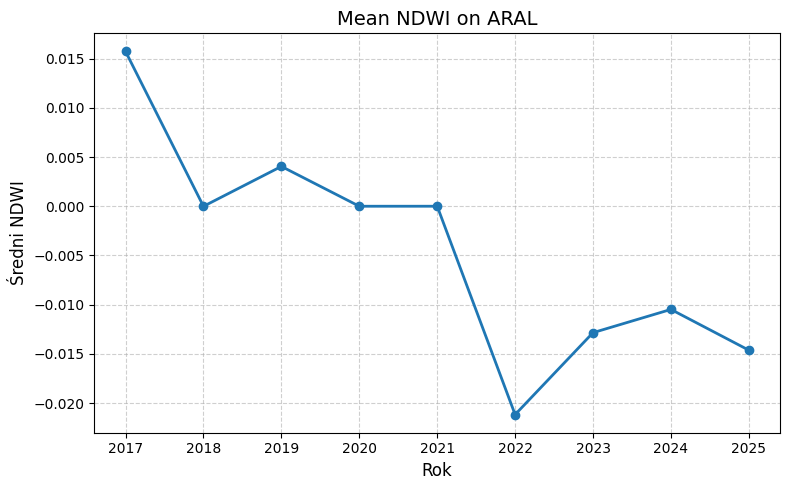

In [14]:
import matplotlib.pyplot as plt
years = sorted(ndwi_means.keys())
values = [ndwi_means[y] for y in years]

plt.figure(figsize=(8, 5))
plt.plot(years, values, marker='o', linestyle='-', linewidth=2)

plt.title("Mean NDWI on ARAL", fontsize=14)
plt.xlabel("Rok", fontsize=12)
plt.ylabel("Średni NDWI", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


## 5) Wizualizacja wyników - wszystkie lata


/tmp/ipykernel_41345/1888644177.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


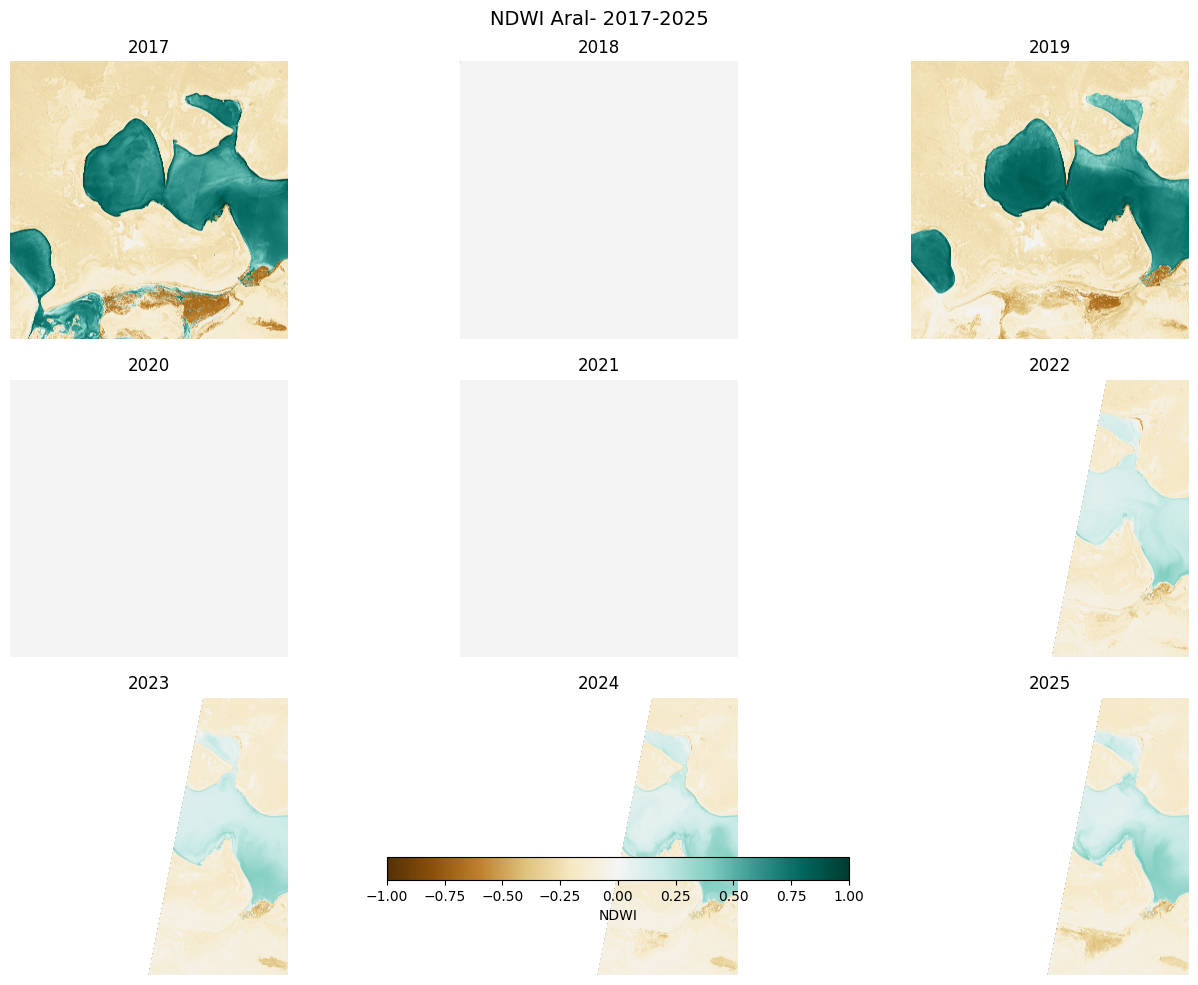

In [1]:
import os
import glob
import numpy as np
import rasterio
import matplotlib.pyplot as plt


output_dir = "/opt/workspace/aut/outpucik/sentinel_ndwi"

ndwi_files = sorted([f for f in os.listdir(output_dir) if f.endswith("_NDWI.tif")])


cols = 3
rows = int(np.ceil(len(ndwi_files) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for i, f in enumerate(ndwi_files):
    path = os.path.join(output_dir, f)
    year = f.split("_")[0]
    with rasterio.open(path) as src:
        ndwi = src.read(1, masked=True)
        img = axes[i].imshow(ndwi, cmap="BrBG", vmin=-1, vmax=1)
        axes[i].set_title(year)
        axes[i].axis("off")


fig.colorbar(img, ax=axes, orientation="horizontal", fraction=0.03, pad=0.05, label="NDWI")
plt.suptitle("NDWI Aral- 2017-2025", fontsize=14)
plt.tight_layout()
plt.show()
